# NYC Yellow Taxi Trip Data from Feburary 2017

_Written by Michael Kamkar_

The main objective of this project is to:

1. Clean a large dataset 
2. Manipulate the dataset 
3. Visualize the dataset with aggregation

using Pyspark, Pandas, and Matplotlib.

The data was processed through my local computer, limiting the allowable size of the dataset. Nonetheless, Pyspark helped to allow processing of a dataset on my computer which otherwise Pandas would not have allowed due to hardware constraints.

The dataset and lookup table was acquired through NYC website:

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#Start session
spark = SparkSession.builder.master("local").appName("NYC Taxi Cab").getOrCreate()

In [3]:
#Create a custom schema for each column to load .csv faster. Does not allow nullable data
custom_schema = StructType([StructField("VendorID", IntegerType(), False),
					 StructField("tpep_pickup_datetime", TimestampType(), False),
                     StructField("tpep_dropoff_datetime", TimestampType(), False),
                     StructField("passenger_count", IntegerType(), False),
                     StructField("trip_distance", DoubleType(), False),
                     StructField("RatecodeID", IntegerType(), False),
                     StructField("store_and_fwd_flag", StringType(), False),
                     StructField("PULocationID", IntegerType(), False),
                     StructField("DOLocationID", IntegerType(), False),
                     StructField("payment_type", IntegerType(), False),
                     StructField("fare_amount", DoubleType(), False),
                     StructField("extra", DoubleType(), False),
                     StructField("mta_tax", DoubleType(), False),
                     StructField("tip_amount", DoubleType(), False),
                     StructField("tolls_amount", DoubleType(), False),
                     StructField("improvement_surcharge", DoubleType(), False),
                     StructField("total_amount", DoubleType(), False),
                     ])


In [4]:
#Load taxi cab data set
df = spark.read.csv("yellow_tripdata_2017-02.csv", header = True, schema = custom_schema, sep = ',')


In [5]:
#Remove unused data columns
droplist = ['extra','mta_tax','improvement_surcharge', 'tolls_amount']
df =df.drop(*droplist)

In [6]:
#look at each individual column to find flaws in dataset. Timestamp columns are empty, pyspark cannot describe them
for col_name in df.columns:
    df.describe(col_name).show()

+-------+------------------+
|summary|          VendorID|
+-------+------------------+
|  count|           9168825|
|   mean|1.5476172792042602|
| stddev|0.4977274572898327|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           9168825|
|   mean|1.6249746287010605|
| stddev|1.2677182840983903|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           9168825|
|   mean|2.8012043211643562|
| stddev|3.5417748929663726|
|    min|               0.0|
|    max|             324.0|
+-------+------------------+

+-------+------------------+
|su

In [7]:
#Create a new column called Duration, which will be the time difference (in minutes) between pickup and dropoff time
timeDiff = (unix_timestamp('tpep_dropoff_datetime')) - (unix_timestamp('tpep_pickup_datetime'))  
df = df.withColumn("Duration", timeDiff/60)                                                       


In [8]:
#Removes nosensical data  
df = df.where(df['fare_amount'] > 2.5)                                    
df = df.where((df['Duration'] > 0) & (df['Duration'] < 180))              
df = df.where((df['PULocationID'] < 264) & (df['DOLocationID'] < 264))    
df = df.where(df['trip_distance'] < 40)                                    
df = df.where(df['passenger_count'] > 0)                                   
df = df.where(month('tpep_pickup_datetime') == 2)                          
df = df.where(df['payment_type'] < 3)                                     
df = df.where(df['RatecodeID'] < 7)                                        #

In [9]:
#Next, change PU/DOLocationID int to Zone name using lookup table

#load .csv file and drop unused columns
lookup = spark.read.csv("taxi _zone_lookup.csv", header = True, sep = ',')
droplist = ['Borough','service_zone']
lookup =lookup.drop(*droplist)


In [10]:
#join dataset and drop unwanted columns
df = df.join(lookup, df.PULocationID == lookup.LocationID, how = 'left')  
df = df.withColumnRenamed('Zone','pickup_location')                      
droplist = ['PULocationID','LocationID']                                   
df = df.drop(*droplist)

In [11]:
#join dataset and drop unwanted columns
df = df.join(lookup, df.DOLocationID == lookup.LocationID, how='left')    
df = df.withColumnRenamed('Zone','dropoff_location')
droplist = ['DOLocationID','LocationID']
df = df.drop(*droplist)


In [12]:
#look at each individual column after processing. Timestamp columns are empty, pyspark cannot describe them
for col_name in df.columns:
    df.describe(col_name).show()

+-------+------------------+
|summary|          VendorID|
+-------+------------------+
|  count|           8894664|
|   mean|1.5554978805270216|
| stddev|0.4969104678083059|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|           8894664|
|   mean|1.6316633208404498|
| stddev|1.2747500090696304|
|    min|                 1|
|    max|                 9|
+-------+------------------+

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|           8894664|
|   mean|2.7901488240590036|
| stddev| 3.448897744825007|
|    min|               0.0|
|    max|             39.98|
+-------+------------------+

+-------+-------------------+
|s

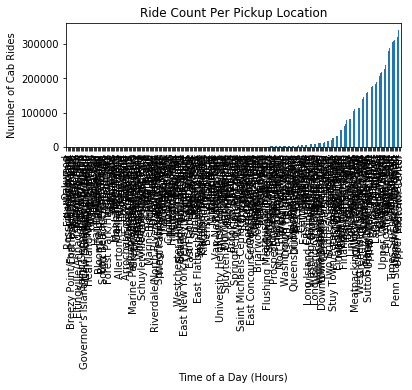

In [13]:
#Create a bar graph counting pickup rides per location
agg_df = df.groupBy('pickup_location').count()                 
agg_df = agg_df.withColumnRenamed('count', 'ride_count')        
pd_df = agg_df.toPandas()
pd_df = pd_df.sort_values(by='ride_count')
pd_df.set_index('pickup_location', inplace = True)                
ax = pd_df.plot.bar(title = 'Ride Count Per Pickup Location',legend=None)       
ax.set(xlabel="Time of a Day (Hours)", ylabel="Number of Cab Rides")
plt.gcf().subplots_adjust(bottom=0.45)
plt.show()

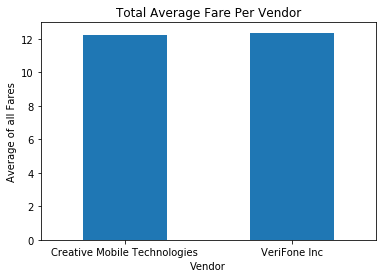

In [14]:
#Creates a bar graph of the average fare amount of all rides for each vendor
agg_df = df.groupby('VendorID').avg('fare_amount')                                                                 
pd_df = agg_df.toPandas()
pd_df['VendorID'] = pd_df['VendorID'].map(lambda x:('Creative Mobile Technologies' if x == 1 else  'VeriFone Inc'))    
pd_df.set_index('VendorID', inplace = True)          
ax = pd_df.plot.bar(rot=0, title = 'Total Average Fare Per Vendor',legend=None)
ax.set(xlabel="Vendor", ylabel="Average of all Fares")
plt.show()

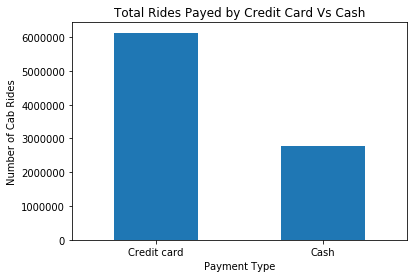

In [15]:
#Creates a bar graph of the count of rides payed by credit card and cash
agg_df = df.groupby('payment_type').count()                   
agg_df = agg_df.withColumnRenamed('count', 'ride_count')       
pd_df = agg_df.toPandas()
pd_df = pd_df.sort_values(by='payment_type')
payment_names = ['Credit card','Cash']  
pd_df['payment_type'] = payment_names                      
pd_df.set_index('payment_type', inplace = True)
ax = pd_df.plot.bar(rot=0, title = 'Total Rides Payed by Credit Card Vs Cash',legend=None)
ax.set(xlabel="Payment Type", ylabel="Number of Cab Rides")
plt.show()

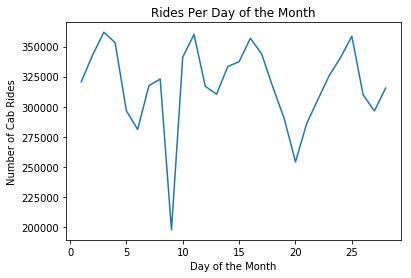

In [16]:
#Creates a graph of pickups per day of the month
agg_df = df.groupBy(window("tpep_pickup_datetime", "1 day",startTime='5 hours')).count()  

agg_df = agg_df.withColumnRenamed('count', 'ride_count')             
agg_df = agg_df.withColumnRenamed('window', 'day')                   
agg_df = agg_df.withColumn("day", agg_df["day"].cast(StringType())) 
pd_df = agg_df.toPandas() 		                                     
pd_df['day'], pd_df['Remove'] = pd_df['day'].str.split(',', 1).str   
pd_df = pd_df.drop(columns = ['Remove'])                             
pd_df['day'] = pd_df['day'].map(lambda x: x.lstrip(']['))             
pickup_datetime  = pd.to_datetime(pd_df["day"])                     
pd_df["day"]  = pickup_datetime.dt.day                                                    
pd_df = pd_df.sort_values(by='day')
pd_df.set_index('day', inplace = True)
ax = pd_df.plot(title = 'Rides Per Day of the Month',legend=None)                  
ax.set(xlabel="Day of the Month", ylabel="Number of Cab Rides")
plt.show()

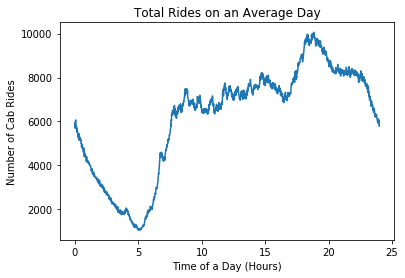

In [17]:
#Creates a plot of the amount of rides taken per minute. Aggregation includes every day of the month
time_of_day = hour('tpep_pickup_datetime') + minute('tpep_pickup_datetime')/60           
df1 = df.select(time_of_day.alias('time_of_day'))                   
agg_df = df1.groupby('time_of_day').count()
agg_df = agg_df.withColumnRenamed('count', 'ride_count')      
pd_df = agg_df.toPandas()
pd_df = pd_df.sort_values(by='time_of_day')
pd_df.set_index('time_of_day', inplace = True)
ax = pd_df.plot(title = 'Total Rides on an Average Day',legend=None)
ax.set(xlabel="Time of a Day (Hours)", ylabel="Number of Cab Rides")
plt.show()

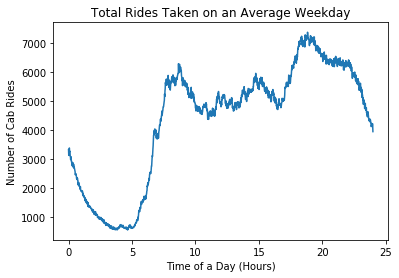

In [18]:
#Creates a plot of the amount of rides taken per minute. Aggregation only includes the weekdays of the month
df1 = df.select('tpep_pickup_datetime', date_format('tpep_pickup_datetime', 'u').alias('day'))
time_of_day = hour('tpep_pickup_datetime')+ minute('tpep_pickup_datetime')/60                 
df1 = df1.withColumn("time_of_day", time_of_day)
agg_df = df1.groupby('time_of_day').pivot('day').count()                       
agg_df = agg_df.drop('6')
agg_df = agg_df.drop('7')
pd_df = agg_df.toPandas()
pd_df['ride_count']= pd_df['1']+pd_df['2']+pd_df['3']+pd_df['4']+pd_df['5']
pd_df=pd_df.drop(columns = ['1','2','3','4','5'])                                   
pd_df = pd_df.sort_values(by='time_of_day')
pd_df.set_index('time_of_day', inplace = True)
ax = pd_df.plot(title = 'Total Rides Taken on an Average Weekday',legend=None)
ax.set(xlabel="Time of a Day (Hours)", ylabel="Number of Cab Rides")
plt.show()

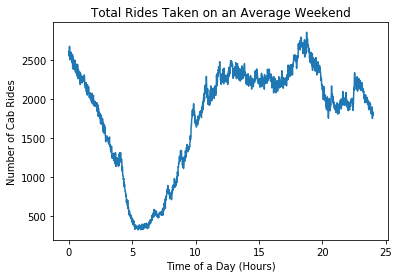

In [19]:
#Creates a plot of the amount of rides taken per minute. Aggregation only includes the weekends of the month
df1 = df.select('tpep_pickup_datetime', date_format('tpep_pickup_datetime', 'u').alias('day')) 
time_of_day = hour('tpep_pickup_datetime')+ minute('tpep_pickup_datetime')/60                  
df1 = df1.withColumn("time_of_day", time_of_day)
agg_df = df1.groupby('time_of_day').pivot('day').count()          
droplist = ['1','2','3','4','5']                                                             
agg_df = agg_df.drop(*droplist)
pd_df = agg_df.toPandas()                                                                    
pd_df['ride_count']= pd_df['6']+pd_df['7']
pd_df=pd_df.drop(columns = ['6','7'])
pd_df = pd_df.sort_values(by='time_of_day')
pd_df.set_index('time_of_day', inplace = True)
ax = pd_df.plot(title = 'Total Rides Taken on an Average Weekend',legend=None)
ax.set(xlabel="Time of a Day (Hours)", ylabel="Number of Cab Rides")
plt.show()	

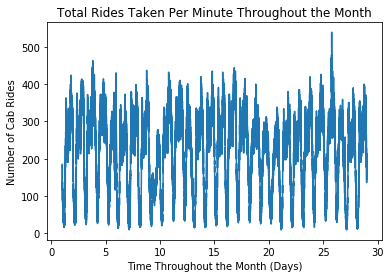

In [20]:
#Creates a plot of the amount of rides taken per minute throughout the whole month
agg_df = df.groupBy(window("tpep_pickup_datetime", "1 minute")).count()                                
agg_df = agg_df.withColumn("window", agg_df["window"].cast(StringType()))                              
agg_df = agg_df.withColumnRenamed('count', 'ride_count')                                              
pd_df = agg_df.toPandas()                                                                              
pd_df['timestamp'], pd_df['Remove'] = pd_df['window'].str.split(',', 1).str                           
pd_df = pd_df.drop(columns = ['Remove'])                                                                
pd_df['timestamp'] = pd_df['timestamp'].map(lambda x: x.lstrip('['))                                   
pickup_datetime  = pd.to_datetime(pd_df["timestamp"])                                                  
pd_df["Time"]  = pickup_datetime.dt.day + pickup_datetime.dt.hour/24 + pickup_datetime.dt.minute/1440
pd_df=pd_df.drop('timestamp',axis=1)                                                                  
pd_df = pd_df.sort_values(by='Time')                                                                    
pd_df.set_index('Time', inplace = True)                                                               
ax = pd_df.plot(title = 'Total Rides Taken Per Minute Throughout the Month',legend=None)               
ax.set(xlabel="Time Throughout the Month (Days)", ylabel="Number of Cab Rides")                        
plt.show()